In [1]:
import sys
import os
home = os.path.expanduser("~")
sys.path.append(f'{home}/TorchFiber')
from src.NewSimulation.config import *

ModuleNotFoundError: No module named 'src'

# 1. Config of fiber

## 1.1 generate initial data

2023-12-27 22:25:23.546436: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):2.0151264667510986
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 400, 1) (1, 25, 1, 1)
0.9999998


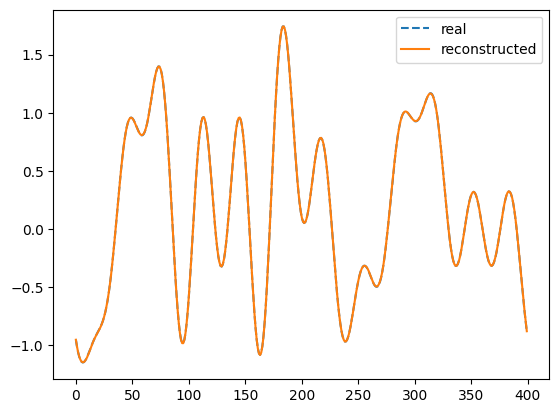

In [2]:
tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=100, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization

print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)
print(np.mean(np.abs(tx_data['signal'])**2))

x = tx_data['signal'][0,:,0]
samples = x[::8]
x_rec = reconstruct(samples, 8)

plt.plot(x.real, '--', label='real')
plt.plot(x_rec.real, label='reconstructed')
plt.legend()

## 1.2 test sampling thm

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/jax/_src/array.py:343: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


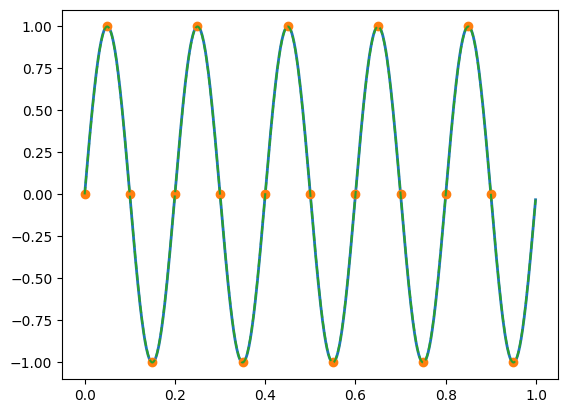

In [3]:
# 定义参数
f_max = 5  # 信号的最高频率
sampling_rate = 2 * f_max  # 采样率（奈奎斯特率）
t = jnp.linspace(0, 1, 1000, endpoint=False)  # 绘图用的时间向量
x = jnp.sin(2 * jnp.pi * f_max * t)
# x = jnp.exp(-(t-0.5)**2*100)

rate = 50
samples = x[::rate]
rec = reconstruct(samples, rate)

plt.plot(t, x, lw=2)
plt.plot(t[::rate], samples, 'o')
plt.plot(t, rec, '--', )

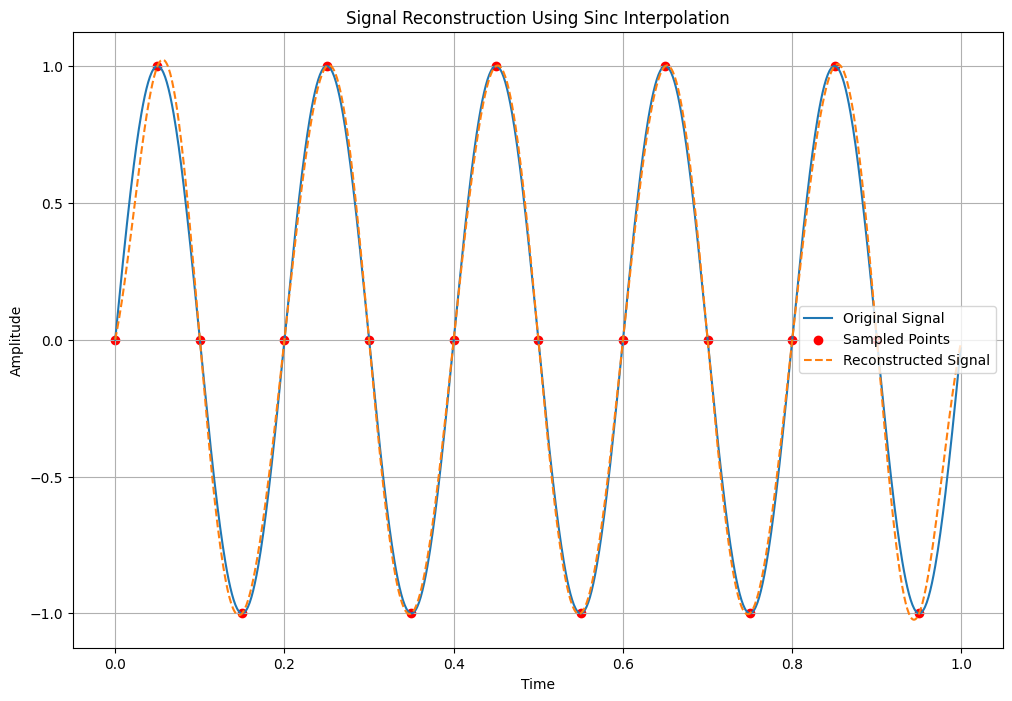

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
f_max = 5  # 信号的最高频率
sampling_rate = 2 * f_max  # 采样率（奈奎斯特率）
T = 0.5*1 / sampling_rate  # 采样间隔
t = np.linspace(0, 1, 1000, endpoint=False)  # 绘图用的时间向量
n = np.arange(0, 1, T)  # 采样点

# 定义信号函数
def signal_function(t):
    # 这里可以定义任何带限信号
    return np.sin(2 * np.pi * f_max * t)

# 原始信号
original_signal = signal_function(t)

# 采样信号值
sampled_values = signal_function(n)

# 重构信号（使用sinc插值）
reconstructed_signal = np.zeros_like(t)
for i in range(len(n)):
    reconstructed_signal += sampled_values[i] * np.sinc((t - n[i]) / T)

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, original_signal, label='Original Signal')
plt.scatter(n, sampled_values, color='red', label='Sampled Points')
plt.plot(t, reconstructed_signal, label='Reconstructed Signal', linestyle='--')
plt.title('Signal Reconstruction Using Sinc Interpolation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


## 1.3 test SSFM convergence

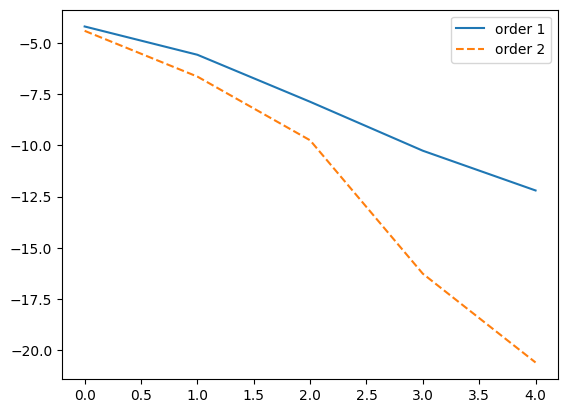

In [5]:
# initial condition
dt = 1/tx_data['config']['sps']
u0 = tx_data['signal'][0,:,0]
z_max = 25*Ls/Ld       # z_max = 2 (Ld)

# dz_ = [0.1/2, 0.1/2**2, 0.1/2**3, 0.1/2**4, 0.1/2**5]
dz_ = [1, 1/2, 1/4, 1/8, 1/16] + [1/2**8]
us1 = []
us2 = []

for dz in dz_:
    u = SSFM(u0, dt, dz, z_max, gamma, order=1)
    us1.append(u)

    u = SSFM(u0, dt, dz, z_max, gamma, order=2)
    us2.append(u)

ur = us2[-1][-1]

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

MSEs1 = [MSE(u[-1], ur) for u in us1[:-1]]
MSEs2 = [MSE(u[-1], ur) for u in us2[:-1]]
plt.plot(np.log2(MSEs1), label='order 1')
plt.plot(np.log2(MSEs2),'--', label='order 2')
plt.legend()

# 2. NLSE

## 2.1 gaussian wave

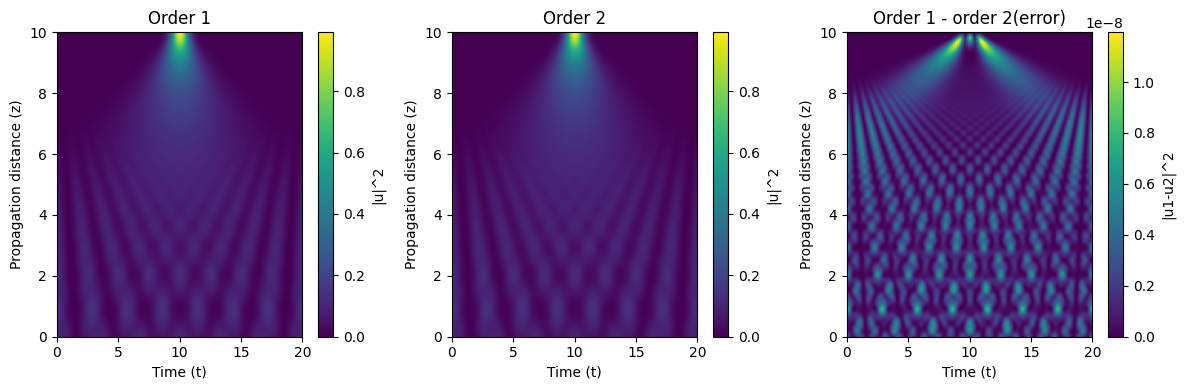

<Figure size 640x480 with 0 Axes>

In [6]:
z_max = 10      # Maximum value of z.  use Ld as unit.
t_max = 20      # Range of t from 0 to t_max.   use symbol time as unit.  (so we have t_max symbols here)
sps = 8         # Samples per symbol
Nt = sps*t_max  # Number of steps in t
Nz = 1000       # Number of steps in z
dz = z_max / Nz
dt = t_max / Nt

# initial condition
t = np.linspace(0, t_max, Nt)
u0 = np.exp(-(t-t_max/2)**2)

u2 = SSFM(u0, dt, dz, z_max, gamma, order=2)
u1 = SSFM(u0, dt, dz, z_max, gamma, order=1)

plt.figure(figsize=(12, 4))
# Plot for order=1
plt.subplot(1, 3, 1)
plt.imshow(np.abs(u1)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u1), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 1')

# Plot for order=2
plt.subplot(1, 3, 2)
plt.imshow(np.abs(u2)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u2), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 2')


# Plot for order1 - order2
plt.subplot(1, 3, 3)
plt.imshow(np.abs(u1 - u2)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u1), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u1-u2|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 1 - order 2(error)')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## 2.2 sinc wave

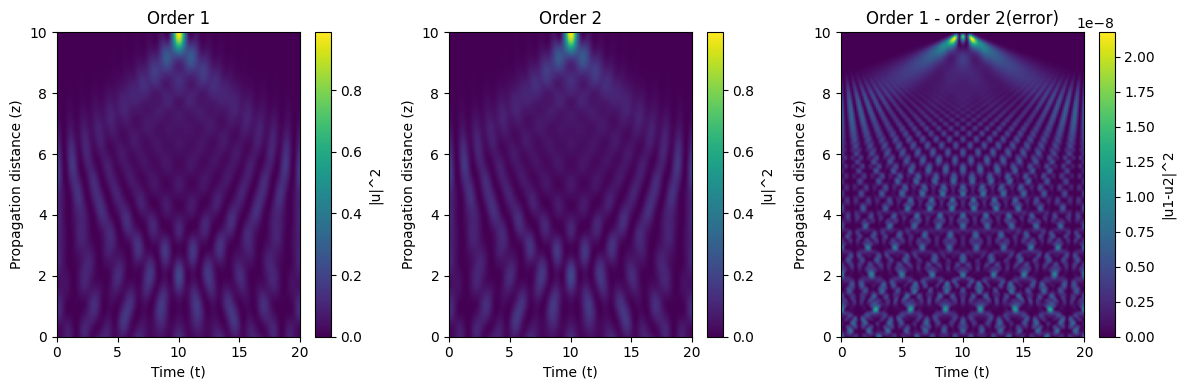

<Figure size 640x480 with 0 Axes>

In [7]:
z_max = 10      # Maximum value of z.  use Ld as unit.
t_max = 20      # Range of t from 0 to t_max.   use symbol time as unit.  (so we have t_max symbols here)
sps = 8         # Samples per symbol
Nt = sps*t_max  # Number of steps in t
Nz = 1000       # Number of steps in z
dz = z_max / Nz
dt = t_max / Nt

# initial condition
t = np.linspace(0, t_max, Nt)
u0 = np.sinc(t - t_max/2)

u2 = SSFM(u0, dt, dz, z_max, gamma, order=2)
u1 = SSFM(u0, dt, dz, z_max, gamma, order=1)

plt.figure(figsize=(12, 4))
# Plot for order=1
plt.subplot(1, 3, 1)
plt.imshow(np.abs(u1)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u1), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 1')

# Plot for order=2
plt.subplot(1, 3, 2)
plt.imshow(np.abs(u2)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u2), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 2')


# Plot for order1 - order2
plt.subplot(1, 3, 3)
plt.imshow(np.abs(u1 - u2)**2, extent=[0, t_max, 0, z_max], aspect='auto')
# plt.imshow(np.angle(u1), extent=[-t_max, t_max, 0, z_max], aspect='auto')
plt.colorbar(label='|u1-u2|^2')
plt.xlabel('Time (t)')
plt.ylabel('Propagation distance (z)')
plt.title('Order 1 - order 2(error)')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## 2.2 16QAM wave

In [8]:
tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=100, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization

print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)
print(np.mean(np.abs(tx_data['signal'])**2))

u0 = tx_data['signal'][0,:,0]

spans = 5
z_max = spans*Ls/Ld
dt = 1/tx_data['config']['sps']

uc = Dispersion(u0, dt, z_max)       # dispersion solution
us = SSFM(u0, dt, dz=1, L=z_max, gamma=gamma, order=1, path=False)     # NLSE solution
ur = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=False)  # real solution


rate = 8
u0_downsamp = u0[::rate]    # sps=16 --> sps=2
uc_downsamp = SSFM(u0_downsamp, dt*rate, dz=z_max,  L=z_max, gamma=0, order=1, path=False)       # dispersion solution
us_downsamp = SSFM(u0_downsamp, dt*rate, dz=1,    L=z_max, gamma=gamma, order=1,path=False)     # NLSE solution
ur_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**8, L=z_max, gamma=gamma, order=2,path=False)  # real solution

uc1 = reconstruct(uc_downsamp, rate)
us1 = reconstruct(us_downsamp, rate)
ur1 = reconstruct(ur_downsamp, rate)

Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):0.09720826148986816
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 400, 1) (1, 25, 1, 1)
0.9999998


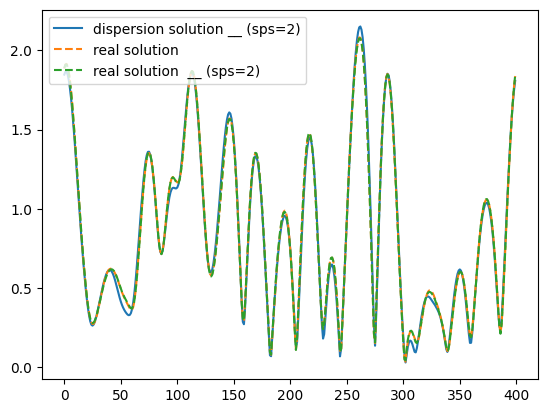

In [9]:
# plt.plot(np.abs(uc), label='dispersion solution')
plt.plot(np.abs(uc1), label='dispersion solution __ (sps=2)')
# plt.plot(us.real, label='SSFM solution: dz=0.5 Ld (4 stps)')   
# plt.plot(us1.real, label='SSFM solution: dz=0.5 Ld (4 stps) __(sps=2)')   
plt.plot(np.abs(ur), '--', label='real solution')
plt.plot(np.abs(ur1), '--', label='real solution  __ (sps=2)')

plt.legend()

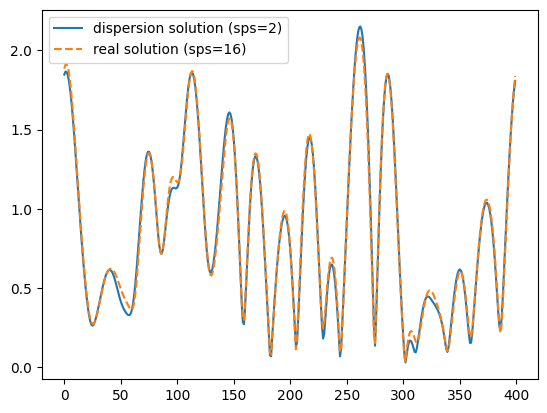

In [10]:
plt.plot(np.abs(uc1), label='dispersion solution (sps=2)')
# plt.plot(np.abs(us1), label='SSFM solution: dz=1 Ld (2 stps) (sps=2)')     
plt.plot(np.abs(ur), '--', label='real solution (sps=16)')

plt.legend()

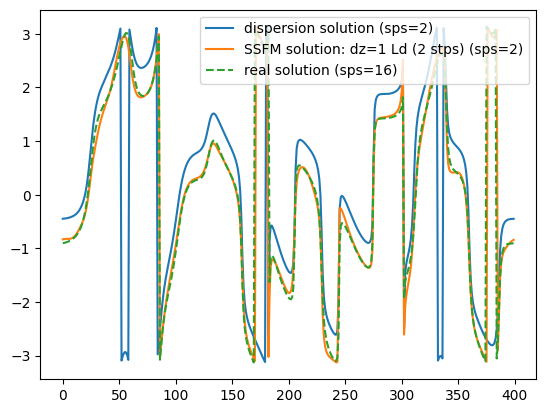

In [11]:
plt.plot(np.angle(uc1), label='dispersion solution (sps=2)')  
plt.plot(np.angle(us1), label='SSFM solution: dz=1 Ld (2 stps) (sps=2)')    
plt.plot(np.angle(ur), '--', label='real solution (sps=16)')

plt.legend()

# 3. pertubation ODE

## 3.1 X coeff

In [12]:
def calc_Xcoeff(dz, z_max, dt, t_max, Ts, N):

    zsteps = int(z_max/dz)
    # initial condition
    t = np.arange(-t_max, t_max, dt)
    u0 = np.sinc(t/Ts)

    us = []
    us.append(u0)
    for i in range(zsteps):
        u = Dispersion(us[-1], dt, dz)
        us.append(u)

    gc = np.stack(us, axis=0)
    steps = int(Ts/dt)
    X = np.zeros((zsteps+1, 2*N+1, 2*N+1, 2*N+1), dtype=complex)
    for m in range(-N, N+1):
        for n in range(-N, N+1):
            for k in range(-N, N+1):
                X[:,m, n, k] = np.sum(np.roll(gc, m*steps, axis=-1)*np.roll(gc, n*steps, axis=-1)*np.roll(gc, k*steps, axis=-1).conj()*gc.conj()*dt, axis=-1)
    return X, np.arange(0, z_max+dz, dz)

# X,z = calc_Xcoeff(1, 10, 0.25, 100, 0.5, 160)
# import pickle n
# pickle.dump((X,z), open('Xcoeff.pkl', 'wb'))

In [15]:
import pickle, numpy as np
X,z = pickle.load(open('../data/Xcoeff_201.pkl', 'rb'))
Xint = np.sum(X*f(z)[:, None, None, None]*z[1], axis=0)

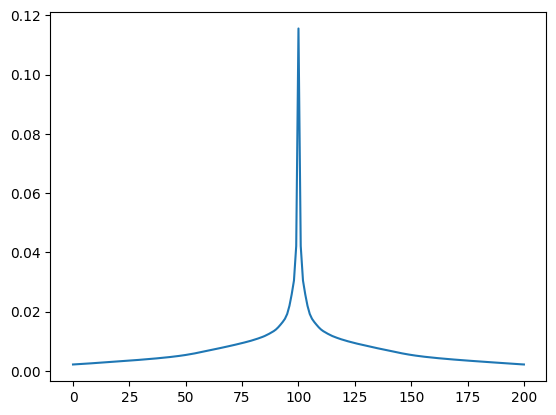

In [16]:
plt.plot(np.fft.fftshift(np.diag(Xint[0,:,:].real)))

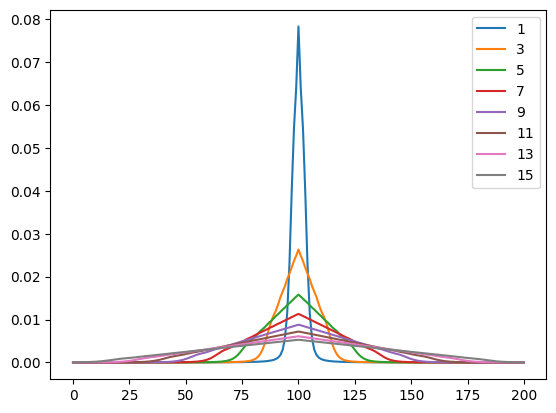

In [17]:
for i in range(1,16,2):
    plt.plot(np.fft.fftshift(np.diag(X[i,0,:,:]).real), label=f'{i}')
plt.legend()

Text(0.5, 1.0, '$\\log\\max_{k}|X_{m,n,k}|$')

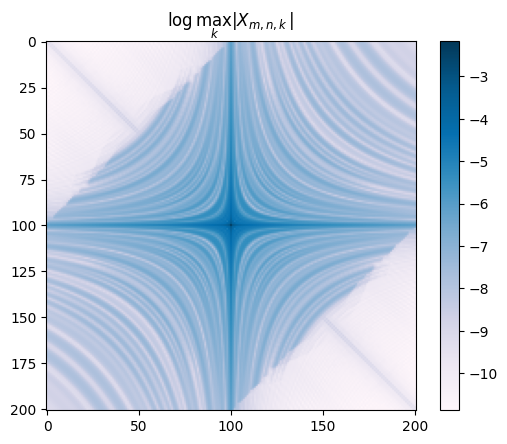

In [18]:
plt.imshow(np.fft.fftshift(np.log(np.max(np.abs(Xint), axis=-1))), cmap='PuBu')
plt.colorbar()
plt.title(r'$\log\max_{k}|X_{m,n,k}|$')

Text(0.5, 1.0, '$X_{m,n,k}$ exponential averaged over $z\\in[0, 2L_d]$  k=12')

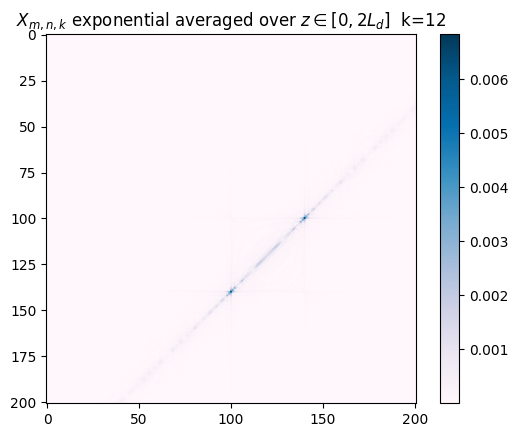

In [19]:
# 展示热力图
plt.imshow(np.fft.fftshift(np.abs(Xint[:,:,40])), cmap='PuBu')
plt.colorbar()
# plt.xticks(np.arange(0, 41, 10), np.arange(-20, 21, 10))
# plt.yticks(np.arange(0, 41, 10), np.arange(-20, 21, 10))
plt.title(r'$X_{m,n,k}$ exponential averaged over $z\in[0, 2L_d]$  k=12')

$$

$$

Text(0.5, 1.0, '$X_{m,n,k}$ exponential averaged over $z\\in[0, 2L_d]$  k=12')

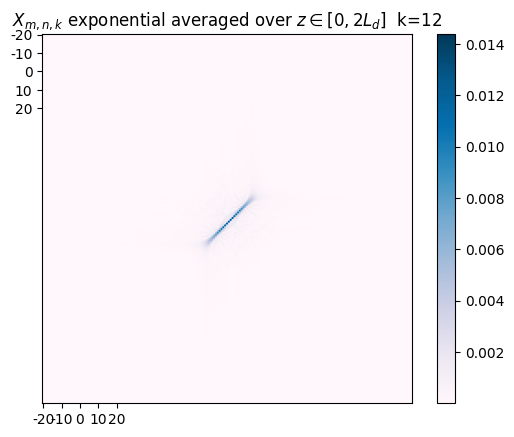

In [20]:
# 展示热力图
plt.imshow(np.fft.fftshift(np.abs(X[5,:,:,3])), cmap='PuBu')
plt.colorbar()
plt.xticks(np.arange(0, 41, 10), np.arange(-20, 21, 10))
plt.yticks(np.arange(0, 41, 10), np.arange(-20, 21, 10))
plt.title(r'$X_{m,n,k}$ exponential averaged over $z\in[0, 2L_d]$  k=12')

(0.0, 1.0)

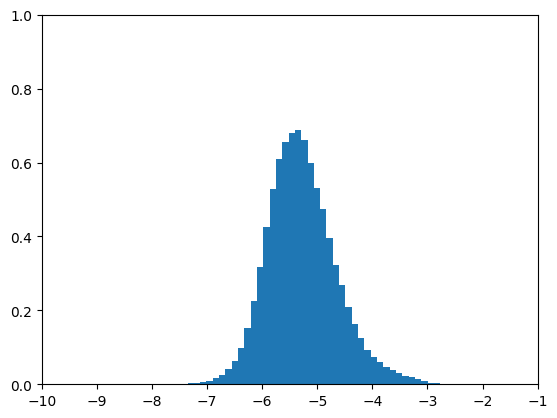

In [21]:
_ = plt.hist(np.log10(np.abs(Xint).reshape(-1)), bins=80, density=True)
plt.xlim(-10,-1)
plt.ylim(0,1)

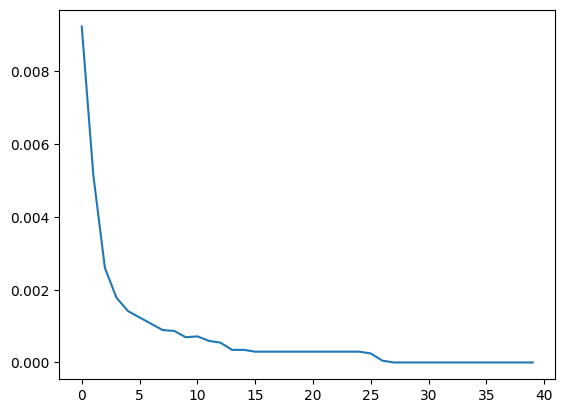

In [22]:
plt.plot([np.mean(np.abs(X[0,:,:,i]) > 1e-3) for i in range(40)])

## 3.2 pertubation 

In [23]:
tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=4000, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization

print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)
print(np.mean(np.abs(tx_data['signal'])**2))

u0 = tx_data['signal'][0,:,0]

spans = 5
z_max = spans*Ls/Ld
dt = 1/tx_data['config']['sps']

uc = Dispersion(u0, dt, z_max)       # dispersion solution
us = SSFM(u0, dt, dz=1, L=z_max, gamma=gamma, order=1, path=False)     # NLSE solution
ur = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=False)  # real solution

Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):1.6252164840698242
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 16000, 1) (1, 1000, 1, 1)
1.0


In [24]:
rate = 8
u0_downsamp = u0[::rate]    # sps=16 --> sps=2
uc_downsamp = SSFM(u0_downsamp, dt*rate, dz=z_max,  L=z_max, gamma=0, order=1, path=False)       # dispersion solution
us_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**6,    L=z_max, gamma=gamma, order=1,path=False)     # NLSE solution
ur_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**8, L=z_max, gamma=gamma, order=2,path=False)  # real solution

uc1 = reconstruct(uc_downsamp, rate)
us1 = reconstruct(us_downsamp, rate)
ur1 = reconstruct(ur_downsamp, rate)

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

print('dispersion only:', MSE(uc, ur))
print('SSFM:', MSE(us1, ur))

dispersion only: 0.2652054952981548
SSFM: 5.231418e-05


In [26]:
import pickle
X,z = pickle.load(open('../data/Xcoeff_161.pkl', 'rb'))
Xint = np.sum(X*f(z)[:, None, None, None]*z[1], axis=0)

def NonlinearCouple(a, X, S, z, dz=1):
    a_delta = np.zeros_like(a)
    for (m,n,k) in S:
        a_delta += f(z)*X[m, n, k]*np.roll(a, m)*np.roll(a, n)*np.roll(a, k).conj()
    return -(1j)*gamma*dz*a_delta

l = X.shape[-1]//2
S1 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1)]
S2 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1) if k == m+n]
S3 = [(m,n,k) for m in range(-l,l+1) for n in range(-l,l+1) for k in range(-l,l+1) if k == m+n and m*n==0]

In [ ]:
u1 = u0_downsamp
for i in range(1):
    # u1 = u1 + NonlinearCouple(u1, X[i], S3, z[i], dz=z[i+1]-z[i])
    u1 = u1*np.exp(NonlinearCouple(u1, X[i], S3, z[i], dz=6)/u1)

u1 = Dispersion(u1, dt*rate, z_max)
u1_rec = reconstruct(u1, rate)

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

print('dispersion only:', MSE(uc, ur))
print('RP1:', MSE(u1_rec, ur))
print('SSFM:', MSE(us1, ur))

dispersion only: 0.2652054952981548
RP1: 0.03444941
SSFM: 0.007886427


In [ ]:


for z_ in np.linspace(0, 3, 40):
    u1 = u0_downsamp
    for i in range(1):
        # u1 = u1 + NonlinearCouple(u1, Xint, S3, 0, dz=z_)
        u1 = u1*np.exp(NonlinearCouple(u1, Xint, S3, 0, dz=z_)/u1)


    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)
    
    print('RP1: z= %.2g:      %.2g ' % (MSE(u1_rec, ur), z_))

RP1: z= 0.27:      0 
RP1: z= 0.23:      0.077 
RP1: z= 0.19:      0.15 
RP1: z= 0.16:      0.23 
RP1: z= 0.13:      0.31 
RP1: z= 0.1:      0.38 
RP1: z= 0.079:      0.46 
RP1: z= 0.059:      0.54 
RP1: z= 0.043:      0.62 
RP1: z= 0.03:      0.69 
RP1: z= 0.02:      0.77 
RP1: z= 0.014:      0.85 
RP1: z= 0.011:      0.92 
RP1: z= 0.012:      1 
RP1: z= 0.017:      1.1 
RP1: z= 0.024:      1.2 
RP1: z= 0.035:      1.2 
RP1: z= 0.05:      1.3 
RP1: z= 0.068:      1.4 
RP1: z= 0.089:      1.5 
RP1: z= 0.11:      1.5 
RP1: z= 0.14:      1.6 
RP1: z= 0.17:      1.7 
RP1: z= 0.21:      1.8 
RP1: z= 0.24:      1.8 
RP1: z= 0.28:      1.9 
RP1: z= 0.33:      2 
RP1: z= 0.37:      2.1 
RP1: z= 0.42:      2.2 
RP1: z= 0.47:      2.2 
RP1: z= 0.53:      2.3 
RP1: z= 0.59:      2.4 
RP1: z= 0.64:      2.5 
RP1: z= 0.71:      2.5 
RP1: z= 0.77:      2.6 
RP1: z= 0.84:      2.7 
RP1: z= 0.9:      2.8 
RP1: z= 0.97:      2.8 
RP1: z= 1:      2.9 
RP1: z= 1.1:      3 


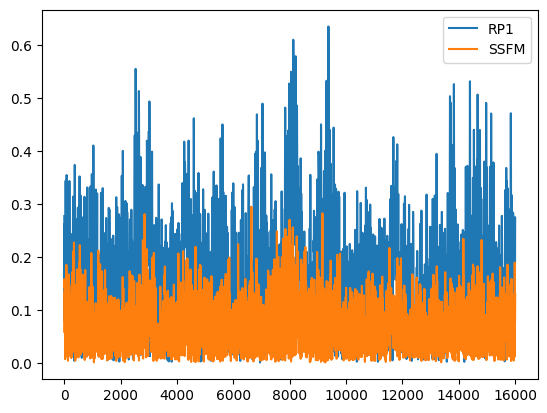

In [ ]:
show_f = np.abs
# plt.plot(show_f(uc - ur), label='dispersion solution')
plt.plot(show_f(u1_rec - ur), label='RP1')
plt.plot(show_f(us1 - ur), label='SSFM')
# plt.plot(show_f(ur), '--', label='real solution')
plt.legend()

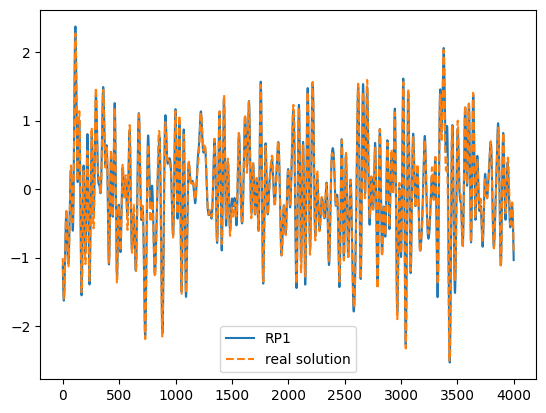

In [ ]:
# plt.plot(uc.real, label='dispersion solution')
plt.plot(u1_rec.real, label='RP1')
plt.plot(ur.real, '--', label='real solution')
plt.legend()

# 4.frequences

In [ ]:
ur_list = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=True)  # real solution

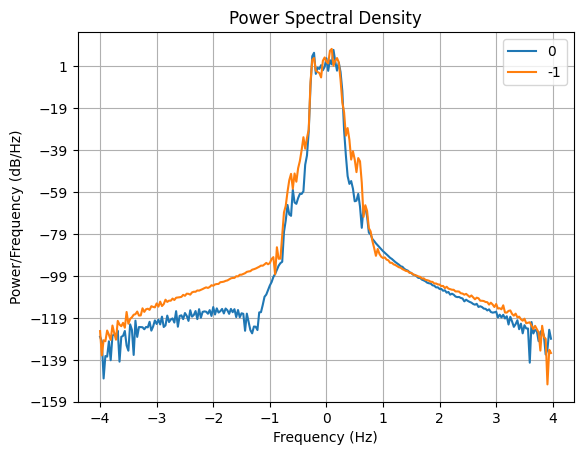

In [ ]:
# Redefine t and compute u0
t = np.linspace(0, t_max, Nt)

# 使用 plt.psd() 绘制PSD
plt.psd(ur_list[0], NFFT=256, Fs=sps, label='0')  # 假设采样率为1000 Hz 
plt.psd(ur_list[-1], NFFT=256, Fs=sps, label='-1')  # 假设采样率为1000 Hz 
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.legend()
plt.show()
